Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [70]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from tensorflow import keras
from datetime import datetime
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [47]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

First reload the data we generated in `1_notmnist.ipynb`.

In [4]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [5]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [16]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

use high-level API with keras instead of low-level API with too many statements.

In [6]:
def classification_print(y_true, y_pred):
    if len(np.shape(y_true)) > 1:
        y_true = np.argmax(y_true, axis=1)
    if len(np.shape(y_pred)) > 1:
        y_pred = np.argmax(y_pred, axis=1)
    print(classification_report(y_true, y_pred))

In [7]:
def train_mnist(X_train=train_dataset, y_train=train_labels, 
                X_test=test_dataset, y_test=test_labels,
                learning_rate = .1,
                dropout = False,
                dropout_rate = .5,
                nn=True,
                multiple_nn = False,
                regularizer=0., 
                epochs=2, 
                batch_size=128,
                optimizer=keras.optimizers.SGD,
                callback = [],
                validation_data=(valid_dataset, valid_labels)):
    reset_graph()
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(784,)))
    if nn:
        if multiple_nn:
            model.add(keras.layers.Dense(100, activation=tf.nn.relu,
                                        kernel_regularizer=keras.regularizers.l2(regularizer)))
            model.add(keras.layers.Dense(100, activation=tf.nn.relu,
                                        kernel_regularizer=keras.regularizers.l2(regularizer)))
        model.add(keras.layers.Dense(1024, activation=tf.nn.relu, 
                                     kernel_regularizer=keras.regularizers.l2(regularizer)))
        if dropout:
            model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(10, activation=tf.nn.softmax, 
                                 kernel_regularizer=keras.regularizers.l2(regularizer)))
    
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=validation_data,
                        callbacks=callback)
    print(f'Test accuracy: {model.evaluate(X_test, y_test, verbose=0)[1]*100:.2f}% with regularizer: {regularizer}')
    classification_print(y_test, model.predict(X_test))
    return model, history

In [8]:
logistic_model, logisitc_history = train_mnist(nn=False)

W0906 23:46:25.837602  5604 deprecation.py:506] From C:\Users\Administrator\Anaconda3\envs\nlp\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 200000 samples, validate on 10000 samples
Epoch 1/2
200000/200000 [==============================] - 2s 12us/sample - loss: 0.6869 - acc: 0.8184 - val_loss: 0.6541 - val_acc: 0.8289
Epoch 2/2
200000/200000 [==============================] - 2s 11us/sample - loss: 0.6409 - acc: 0.8301 - val_loss: 0.6506 - val_acc: 0.8284
Test accuracy: 89.68% with regularizer: 0.0
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1000
           1       0.91      0.89      0.90      1000
           2       0.91      0.93      0.92      1000
           3       0.93      0.92      0.92      1000
           4       0.92      0.86      0.89      1000
           5       0.90      0.93      0.91      1000
           6       0.87      0.90      0.88      1000
           7       0.88      0.90      0.89      1000
           8       0.86      0.86      0.86      1000
           9       0.86      0.90      0.88      1000

    accuracy                 

In [214]:
logistic_model.summary()

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_91 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_136 (Dense)            (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [163]:
logistic_model, logisitc_history = train_mnist(nn=False, regularizer=.01)

Train on 200000 samples, validate on 10000 samples
Epoch 1/2
200000/200000 [==============================] - 4s 21us/sample - loss: 0.8282 - acc: 0.8146 - val_loss: 0.7857 - val_acc: 0.8202
Epoch 2/2
200000/200000 [==============================] - 3s 17us/sample - loss: 0.7795 - acc: 0.8214 - val_loss: 0.7874 - val_acc: 0.8186
Test accuracy: 88.85% with regularizer:0.01
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      1000
           1       0.93      0.87      0.90      1000
           2       0.91      0.93      0.92      1000
           3       0.91      0.91      0.91      1000
           4       0.91      0.86      0.89      1000
           5       0.91      0.91      0.91      1000
           6       0.90      0.89      0.90      1000
           7       0.92      0.87      0.89      1000
           8       0.80      0.86      0.83      1000
           9       0.80      0.89      0.85      1000

    accuracy                 

In [162]:
logistic_model, logisitc_history = train_mnist(nn=False, regularizer=.001)

Train on 200000 samples, validate on 10000 samples
Epoch 1/2
200000/200000 [==============================] - 4s 18us/sample - loss: 0.7152 - acc: 0.8181 - val_loss: 0.6869 - val_acc: 0.8262
Epoch 2/2
200000/200000 [==============================] - 3s 15us/sample - loss: 0.6696 - acc: 0.8290 - val_loss: 0.6739 - val_acc: 0.8304
Test accuracy: 89.71% with regularizer:0.001
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1000
           1       0.92      0.89      0.90      1000
           2       0.89      0.93      0.91      1000
           3       0.91      0.93      0.92      1000
           4       0.90      0.87      0.88      1000
           5       0.92      0.92      0.92      1000
           6       0.91      0.89      0.90      1000
           7       0.90      0.89      0.90      1000
           8       0.84      0.85      0.85      1000
           9       0.86      0.90      0.88      1000

    accuracy                

In [164]:
logistic_model, logisitc_history = train_mnist(nn=False, regularizer=1)

Train on 200000 samples, validate on 10000 samples
Epoch 1/2
200000/200000 [==============================] - 4s 19us/sample - loss: 1.9211 - acc: 0.7070 - val_loss: 1.9044 - val_acc: 0.6929
Epoch 2/2
200000/200000 [==============================] - 3s 15us/sample - loss: 1.8839 - acc: 0.7074 - val_loss: 1.8995 - val_acc: 0.6621
Test accuracy: 72.71% with regularizer:1
              precision    recall  f1-score   support

           0       0.94      0.68      0.79      1000
           1       0.79      0.74      0.76      1000
           2       0.55      0.89      0.68      1000
           3       0.89      0.80      0.84      1000
           4       0.87      0.66      0.75      1000
           5       0.93      0.76      0.84      1000
           6       0.96      0.36      0.52      1000
           7       0.92      0.66      0.77      1000
           8       0.69      0.83      0.75      1000
           9       0.45      0.89      0.60      1000

    accuracy                    

In [146]:
nn_model, nn_history = train_mnist()

Train on 200000 samples, validate on 10000 samples
Epoch 1/2
200000/200000 [==============================] - 17s 83us/sample - loss: 0.7475 - acc: 0.7993 - val_loss: 0.6105 - val_acc: 0.8295
Epoch 2/2
200000/200000 [==============================] - 16s 78us/sample - loss: 0.5760 - acc: 0.8369 - val_loss: 0.5637 - val_acc: 0.8406
Test accuracy: 90.85% with regularizer:0.0
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1000
           1       0.91      0.89      0.90      1000
           2       0.91      0.94      0.93      1000
           3       0.93      0.92      0.92      1000
           4       0.93      0.88      0.90      1000
           5       0.92      0.93      0.92      1000
           6       0.91      0.91      0.91      1000
           7       0.93      0.90      0.91      1000
           8       0.87      0.88      0.87      1000
           9       0.86      0.93      0.89      1000

    accuracy                

In [147]:
nn_model, nn_history = train_mnist(regularizer=.01)

Train on 200000 samples, validate on 10000 samples
Epoch 1/2
200000/200000 [==============================] - 19s 96us/sample - loss: 7.6053 - acc: 0.7969 - val_loss: 5.6360 - val_acc: 0.8211
Epoch 2/2
200000/200000 [==============================] - 20s 98us/sample - loss: 4.3910 - acc: 0.8280 - val_loss: 3.3957 - val_acc: 0.8275
Test accuracy: 89.37% with regularizer:0.01
              precision    recall  f1-score   support

           0       0.94      0.90      0.91      1000
           1       0.92      0.87      0.89      1000
           2       0.90      0.92      0.91      1000
           3       0.92      0.91      0.91      1000
           4       0.91      0.85      0.88      1000
           5       0.87      0.94      0.90      1000
           6       0.92      0.89      0.90      1000
           7       0.91      0.88      0.90      1000
           8       0.85      0.86      0.85      1000
           9       0.83      0.92      0.87      1000

    accuracy               

In [148]:
nn_model, nn_history = train_mnist(regularizer=.001)

Train on 200000 samples, validate on 10000 samples
Epoch 1/2
200000/200000 [==============================] - 20s 102us/sample - loss: 1.6407 - acc: 0.7981 - val_loss: 1.4793 - val_acc: 0.8293
Epoch 2/2
200000/200000 [==============================] - 20s 98us/sample - loss: 1.4250 - acc: 0.8357 - val_loss: 1.3890 - val_acc: 0.8392
Test accuracy: 90.80% with regularizer:0.001
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1000
           1       0.92      0.89      0.90      1000
           2       0.92      0.93      0.92      1000
           3       0.92      0.93      0.92      1000
           4       0.92      0.88      0.90      1000
           5       0.90      0.94      0.92      1000
           6       0.91      0.91      0.91      1000
           7       0.92      0.89      0.91      1000
           8       0.87      0.86      0.87      1000
           9       0.87      0.94      0.90      1000

    accuracy             

In [150]:
nn_model, nn_history = train_mnist(regularizer=.0001)

Train on 200000 samples, validate on 10000 samples
Epoch 1/2
200000/200000 [==============================] - 21s 107us/sample - loss: 0.8338 - acc: 0.8003 - val_loss: 0.7018 - val_acc: 0.8293
Epoch 2/2
200000/200000 [==============================] - 20s 99us/sample - loss: 0.6684 - acc: 0.8368 - val_loss: 0.6560 - val_acc: 0.8411
Test accuracy: 90.64% with regularizer:0.0001
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1000
           1       0.91      0.88      0.90      1000
           2       0.93      0.93      0.93      1000
           3       0.90      0.92      0.91      1000
           4       0.92      0.89      0.90      1000
           5       0.89      0.94      0.91      1000
           6       0.91      0.91      0.91      1000
           7       0.91      0.90      0.91      1000
           8       0.87      0.87      0.87      1000
           9       0.88      0.92      0.90      1000

    accuracy            

In [149]:
nn_model, nn_history = train_mnist(regularizer=1)

Train on 200000 samples, validate on 10000 samples
Epoch 1/2
200000/200000 [==============================] - 18s 92us/sample - loss: 17.0011 - acc: 0.1571 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/2
200000/200000 [==============================] - 18s 89us/sample - loss: 2.3026 - acc: 0.0993 - val_loss: 2.3026 - val_acc: 0.1000
Test accuracy: 10.00% with regularizer:1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.10      1.00      0.18      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                 

C:\Users\Administrator\Anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [167]:
log_model, _ = train_mnist(X_train=train_dataset[:1000,:],y_train = train_labels[:1000,:],nn=False, regularizer=.001)

Train on 1000 samples, validate on 10000 samples
Epoch 1/2
1000/1000 [==============================] - 1s 934us/sample - loss: 1.9120 - acc: 0.3740 - val_loss: 1.3868 - val_acc: 0.6379
Epoch 2/2
1000/1000 [==============================] - 0s 133us/sample - loss: 1.2468 - acc: 0.6930 - val_loss: 1.1163 - val_acc: 0.7276
Test accuracy: 79.80% with regularizer:0.001
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1000
           1       0.88      0.75      0.81      1000
           2       0.82      0.80      0.81      1000
           3       0.83      0.83      0.83      1000
           4       0.77      0.71      0.74      1000
           5       0.68      0.91      0.78      1000
           6       0.81      0.82      0.81      1000
           7       0.90      0.75      0.82      1000
           8       0.80      0.79      0.80      1000
           9       0.68      0.83      0.75      1000

    accuracy                        

In [168]:
nn_model, _ = train_mnist(X_train=train_dataset[:1000,:], y_train = train_labels[:1000,:],regularizer=.001)

Train on 1000 samples, validate on 10000 samples
Epoch 1/2
1000/1000 [==============================] - 1s 1ms/sample - loss: 2.6493 - acc: 0.4890 - val_loss: 2.1322 - val_acc: 0.7096
Epoch 2/2
1000/1000 [==============================] - 1s 537us/sample - loss: 1.9840 - acc: 0.7360 - val_loss: 1.8774 - val_acc: 0.7553
Test accuracy: 82.98% with regularizer:0.001
              precision    recall  f1-score   support

           0       0.77      0.84      0.80      1000
           1       0.90      0.81      0.85      1000
           2       0.79      0.91      0.84      1000
           3       0.81      0.88      0.84      1000
           4       0.89      0.76      0.82      1000
           5       0.76      0.92      0.83      1000
           6       0.91      0.78      0.84      1000
           7       0.91      0.80      0.85      1000
           8       0.78      0.84      0.81      1000
           9       0.85      0.77      0.80      1000

    accuracy                          

Test accuracy is lower due to overfitting.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [146]:
nn_model, nn_history = train_mnist()

Train on 200000 samples, validate on 10000 samples
Epoch 1/2
200000/200000 [==============================] - 17s 83us/sample - loss: 0.7475 - acc: 0.7993 - val_loss: 0.6105 - val_acc: 0.8295
Epoch 2/2
200000/200000 [==============================] - 16s 78us/sample - loss: 0.5760 - acc: 0.8369 - val_loss: 0.5637 - val_acc: 0.8406
Test accuracy: 90.85% with regularizer:0.0
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1000
           1       0.91      0.89      0.90      1000
           2       0.91      0.94      0.93      1000
           3       0.93      0.92      0.92      1000
           4       0.93      0.88      0.90      1000
           5       0.92      0.93      0.92      1000
           6       0.91      0.91      0.91      1000
           7       0.93      0.90      0.91      1000
           8       0.87      0.88      0.87      1000
           9       0.86      0.93      0.89      1000

    accuracy                

In [170]:
nn_model, _ = train_mnist(dropout=True)

Train on 200000 samples, validate on 10000 samples
Epoch 1/2
200000/200000 [==============================] - 18s 89us/sample - loss: 0.5876 - acc: 0.8310 - val_loss: 0.4786 - val_acc: 0.8631
Epoch 2/2
200000/200000 [==============================] - 17s 85us/sample - loss: 0.4820 - acc: 0.8598 - val_loss: 0.4295 - val_acc: 0.8802
Test accuracy: 93.73% with regularizer:0.0
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1000
           1       0.94      0.93      0.93      1000
           2       0.94      0.96      0.95      1000
           3       0.93      0.95      0.94      1000
           4       0.96      0.92      0.94      1000
           5       0.96      0.95      0.95      1000
           6       0.92      0.94      0.93      1000
           7       0.95      0.94      0.94      1000
           8       0.93      0.90      0.91      1000
           9       0.91      0.95      0.93      1000

    accuracy                

In [171]:
nn_model, _ = train_mnist(dropout=True, regularizer=.001)

Train on 200000 samples, validate on 10000 samples
Epoch 1/2
200000/200000 [==============================] - 22s 109us/sample - loss: 1.2888 - acc: 0.8313 - val_loss: 1.0201 - val_acc: 0.8598
Epoch 2/2
200000/200000 [==============================] - 21s 104us/sample - loss: 0.9063 - acc: 0.8566 - val_loss: 0.7808 - val_acc: 0.8690
Test accuracy: 92.87% with regularizer:0.001
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1000
           1       0.92      0.93      0.92      1000
           2       0.93      0.95      0.94      1000
           3       0.93      0.93      0.93      1000
           4       0.95      0.92      0.93      1000
           5       0.93      0.95      0.94      1000
           6       0.92      0.93      0.92      1000
           7       0.97      0.91      0.94      1000
           8       0.92      0.89      0.90      1000
           9       0.87      0.95      0.91      1000

    accuracy            

Dropout did a great job on avoiding overfitting.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [296]:
# EarlyStopping's monitor should use validation_data's params, like val_loss or val_acc.
stop_callback = keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=2)
checkpoint_path='checkpoint/nn_model.ckpt'
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                            monitor='val_acc',
                                            verbose=1,
                                            save_best_only=True,
                                            load_weights_on_restart=True)

In [277]:
nn_model, _ = train_mnist(multiple_nn=True, dropout=True, callback=[stop_callback, checkpoint])

Train on 200000 samples, validate on 10000 samples
Epoch 1/2
199168/200000 [============================>.] - ETA: 0s - loss: 0.1163 - acc: 0.9599
Epoch 00001: val_acc improved from -inf to 0.91080, saving model to checkpoint/nn_model.ckpt
200000/200000 [==============================] - 12s 62us/sample - loss: 0.1162 - acc: 0.9599 - val_loss: 0.5095 - val_acc: 0.9108
Epoch 2/2
199936/200000 [============================>.] - ETA: 0s - loss: 0.1119 - acc: 0.9614
Epoch 00002: val_acc improved from 0.91080 to 0.91140, saving model to checkpoint/nn_model.ckpt
200000/200000 [==============================] - 12s 61us/sample - loss: 0.1119 - acc: 0.9614 - val_loss: 0.5149 - val_acc: 0.9114
Test accuracy: 95.98% with regularizer: 0.0
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1000
           1       0.95      0.96      0.96      1000
           2       0.96      0.96      0.96      1000
           3       0.97      0.97      0.97  

now try decay learning rate.

In [281]:
initial_learning_rate = .1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                        decay_steps = 10000,
                                                        decay_rate = .96,
                                                        staircase = True)
nn_model, _ = train_mnist(multiple_nn=True, dropout=True, 
                          epochs=10, learning_rate=lr_schedule,
                         callback=[stop_callback, checkpoint])

Train on 200000 samples, validate on 10000 samples
Epoch 1/10
199424/200000 [============================>.] - ETA: 0s - loss: 0.1030 - acc: 0.9647
Epoch 00001: val_acc did not improve from 0.91140
200000/200000 [==============================] - 12s 62us/sample - loss: 0.1030 - acc: 0.9647 - val_loss: 0.5373 - val_acc: 0.9100
Epoch 2/10
199936/200000 [============================>.] - ETA: 0s - loss: 0.0995 - acc: 0.9659
Epoch 00002: val_acc did not improve from 0.91140
200000/200000 [==============================] - 12s 62us/sample - loss: 0.0995 - acc: 0.9660 - val_loss: 0.5499 - val_acc: 0.9112
Epoch 3/10
199552/200000 [============================>.] - ETA: 0s - loss: 0.1046 - acc: 0.9635
Epoch 00003: val_acc did not improve from 0.91140
200000/200000 [==============================] - 12s 61us/sample - loss: 0.1046 - acc: 0.9635 - val_loss: 0.5527 - val_acc: 0.9103
Epoch 4/10
199168/200000 [============================>.] - ETA: 0s - loss: 0.1012 - acc: 0.9651
Epoch 00004: val_a

In [282]:
nn_model, _ = train_mnist(multiple_nn=True, dropout=True, dropout_rate=.3, epochs=10,learning_rate=lr_schedule,
                         callback=[stop_callback, checkpoint])

Train on 200000 samples, validate on 10000 samples
Epoch 1/10
199680/200000 [============================>.] - ETA: 0s - loss: 0.0987 - acc: 0.9664
Epoch 00001: val_acc did not improve from 0.91140
200000/200000 [==============================] - 12s 62us/sample - loss: 0.0987 - acc: 0.9664 - val_loss: 0.5307 - val_acc: 0.9092
Epoch 2/10
199680/200000 [============================>.] - ETA: 0s - loss: 0.0940 - acc: 0.9680
Epoch 00002: val_acc did not improve from 0.91140
200000/200000 [==============================] - 12s 60us/sample - loss: 0.0940 - acc: 0.9680 - val_loss: 0.5422 - val_acc: 0.9114
Epoch 3/10
199296/200000 [============================>.] - ETA: 0s - loss: 0.0933 - acc: 0.9681
Epoch 00003: val_acc did not improve from 0.91140
200000/200000 [==============================] - 12s 60us/sample - loss: 0.0933 - acc: 0.9680 - val_loss: 0.5618 - val_acc: 0.9092
Epoch 4/10
199424/200000 [============================>.] - ETA: 0s - loss: 0.0898 - acc: 0.9697
Epoch 00004: val_a

In [285]:
nn_model, _ = train_mnist(multiple_nn=True, dropout=True, dropout_rate=.3, epochs=10,learning_rate=lr_schedule,
                          batch_size=32,
                         callback=[stop_callback, checkpoint])

Train on 200000 samples, validate on 10000 samples
Epoch 1/10
199648/200000 [============================>.] - ETA: 0s - loss: 0.1546 - acc: 0.9492
Epoch 00001: val_acc did not improve from 0.91150
200000/200000 [==============================] - 27s 137us/sample - loss: 0.1546 - acc: 0.9492 - val_loss: 0.4004 - val_acc: 0.9069
Epoch 2/10
199616/200000 [============================>.] - ETA: 0s - loss: 0.1535 - acc: 0.9487
Epoch 00002: val_acc did not improve from 0.91150
200000/200000 [==============================] - 27s 134us/sample - loss: 0.1534 - acc: 0.9488 - val_loss: 0.4086 - val_acc: 0.9087
Epoch 3/10
199968/200000 [============================>.] - ETA: 0s - loss: 0.1489 - acc: 0.9504
Epoch 00003: val_acc did not improve from 0.91150
200000/200000 [==============================] - 27s 136us/sample - loss: 0.1489 - acc: 0.9504 - val_loss: 0.4230 - val_acc: 0.9077
Epoch 4/10
199904/200000 [============================>.] - ETA: 0s - loss: 0.1430 - acc: 0.9518
Epoch 00004: va

try a whole new structure

In [ ]:
reset_graph()
checkpoint_path = 'checkpoint/nn_model_final.ckpt'
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                            monitor='val_acc',
                                            verbose=1,
                                            save_best_only=True,
                                            load_weights_on_restart=True)
model_final = keras.models.Sequential([
    keras.layers.Dense(4*784, input_shape=(784,), activation=tf.nn.relu),
    keras.layers.Dropout(.5),
    keras.layers.Dense(2*784, activation=tf.nn.relu),
    keras.layers.Dropout(.5),
    keras.layers.Dense(784, activation=tf.nn.relu),
    keras.layers.Dropout(.5),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model_final.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_final.fit(train_dataset, train_labels, batch_size=1024,
                validation_data=(valid_dataset, valid_labels),
                epochs=1000,
                callbacks=[stop_callback, checkpoint])

In [300]:
model_final.evaluate(test_dataset, test_labels)

10000/10000 [==============================] - 4s 439us/sample - loss: 0.1437 - acc: 0.9588


[0.14367311419695616, 0.9588]

1 hour trainging with complicated structure seems not that powerful as expected.

maybe more training data is needed.

datasets from example is 200k, while notMNIST dataset got 520k training data, higher accuracy need more data, perhaps?

implemented on service or with GPU is an option.

use CNN will have better result.implement it later.

get all datasets.

In [3]:
train_file = r"D:\Github\NLP\Artificial_Intelligence_for_NLP\Week_09_0831_kmeans_NN\assignments\notMNIST_large"
test_file = r"D:\Github\NLP\Artificial_Intelligence_for_NLP\Week_09_0831_kmeans_NN\assignments\notMNIST_small"

In [45]:
summary = np.zeros((1,28,28))
summary_labels = np.zeros(1)

test_summary = np.zeros((1, 28, 28))
test_summary_labels = np.zeros(1)

for p in os.listdir(train_file):
    pickle_path = os.path.join(train_file, p)
    if os.path.isfile(pickle_path):
        index = 'ABCDEFGHIJ'.index(os.path.splitext(pickle_path)[0][-1])
        with open(pickle_path, 'rb') as f:
            temp = pickle.load(f)
            size = temp.shape[0]
            summary = np.r_[summary, temp]
            summary_labels = np.r_[summary_labels, np.full((size,),index)]


for p in os.listdir(test_file):
    pickle_path = os.path.join(test_file, p)
    if os.path.isfile(pickle_path):
        index = 'ABCDEFGHIJ'.index(os.path.splitext(pickle_path)[0][-1])
        with open(pickle_path, 'rb') as f:
            temp = pickle.load(f)
            size = temp.shape[0]
            test_summary = np.r_[test_summary, temp]
            test_summary_labels = np.r_[test_summary_labels, np.full((size,),index)]

save data.

In [49]:
with open('allMNIST.pickle', 'wb') as f:
    save = {
        'train_dataset': summary[1:],
        'train_labels': summary_labels[1:],
        'test_dataset': test_summary[1:],
        'test_labels': test_summary_labels[1:]
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)

load data.

In [57]:
with open('allMNIST.pickle', 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save


def shuffle(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels


train_dataset, train_labels = shuffle(train_dataset, train_labels)
test_dataset, test_labels = shuffle(test_dataset, test_labels)
encoder = OneHotEncoder(categories='auto')
train_labels_1hot = encoder.fit_transform(train_labels.reshape(-1,1)).toarray()
test_labels_1hot = encoder.fit_transform(test_labels.reshape(-1,1)).toarray()
train_flatten = train_dataset.reshape(-1, 784)
test_flatten = test_dataset.reshape(-1, 784)

In [58]:
train_dataset.shape, train_labels.shape, test_dataset.shape, test_labels.shape

((529114, 28, 28), (529114,), (18724, 28, 28), (18724,))

let's train model on service with more CPUs computation resource.

In [53]:
def log_dir(prefix=''):
    now = datetime.now().strftime('%Y%m%d_%H%M%S')
    root_logdir = 'tf_logs'
    if prefix:
        prefix += '-'
    name = prefix + 'run_' + now
    return os.path.join(root_logdir, name)


logdir = log_dir('high_level_API')

In [ ]:
def train():
    reset_graph()
    checkpoint_path = 'tmp/high_level_API_complicate_CNN'
    units = 28 * 28
    initial_learning_rate = .1
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                                 decay_steps=10000,
                                                                 decay_rate=.96,
                                                                 staircase=True)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor='val_acc',
                                                     verbose=1,
                                                     save_best_only=True,
                                                     load_weights_on_restart=True)
    stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                                     mode='max',
                                                     patience=10)
    csv_logger = tf.keras.callbacks.CSVLogger('csv_logger')
    tensorboard = tf.keras.callbacks.TensorBoard(logdir)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(4 * units, activation=tf.nn.relu, input_shape=(784, )),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(2 * units, activation=tf.nn.relu),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(units, activation=tf.nn.relu),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(lr_schedule),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_flatten, train_labels_1hot, validation_split=.2,
              epochs=100, batch_size=1024, callbacks=[cp_callback,
                                     stop_callback,
                                     csv_logger,
                                     tensorboard])

    print("Model's performance on test dataset:")
    print(f"Test accuracy: {model.evaluate(test_flatten, test_labels_1hot)[1] * 100:.3f}%")
    model.save('model.h5')


if __name__ == '__main__':
    train()

get trained model from service.

In [60]:
model = keras.models.load_model('final_model.h5')

W0908 00:04:42.193841  6940 deprecation.py:506] From C:\Users\Administrator\Anaconda3\envs\nlp\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0908 00:04:42.196840  6940 deprecation.py:506] From C:\Users\Administrator\Anaconda3\envs\nlp\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [64]:
model.evaluate(test_flatten, test_labels_1hot)

18724/18724 [==============================] - 7s 399us/sample - loss: 0.0904 - acc: 0.9767s - loss: 0.0885 - acc: 0 - ETA: 0s - loss: 0.0901 - a


[0.09038804665404582, 0.97666097]

dingding! got test accuracy with `97.67%`

In [92]:
df1 = pd.read_csv('csv_logger_1')
df2 = pd.read_csv('csv_logger')

In [90]:
df.head()

,epoch,acc,loss,val_acc,val_loss
0,0,0.848216,0.498431,0.886376,0.371921
1,1,0.877139,0.402231,0.895146,0.341904
2,2,0.886716,0.368978,0.900523,0.320959
3,3,0.893610,0.344003,0.907572,0.302903
4,4,0.898739,0.327150,0.910152,0.295743


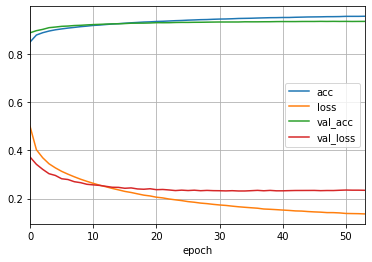

In [93]:
df1.plot(x='epoch', y=['acc', 'loss', 'val_acc', 'val_loss'], grid=True)
plt.show()

after change batch_size from 32 to 1024 and training continue from checkpoint.

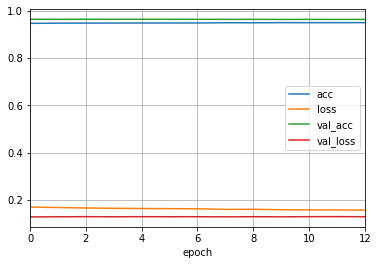

In [94]:
df2.plot(x='epoch', y=['acc', 'loss', 'val_acc', 'val_loss'], grid=True)
plt.show()